# AWACでマリオを動かしてみる

## 下準備

In [1]:
import sys
import os
import random

import gym
import ppaquette_gym_super_mario
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from src.Learner.AWAC import AWAC
from src.utils.memory import ReplayMemory
from src.utils.train_utils import prepare_training_inputs

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class MaxAndSkipEnv(gym.Wrapper):
    
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        
        return self.env.reset(**kwargs)


class WarpFrame(gym.ObservationWrapper):
    
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs


class ClipRewardEnv(gym.RewardWrapper):
    
    def __init__(self, env):
        
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        
        return np.sign(reward)


class LazyFrames(object):
    
    def __init__(self, frames):
        
        self._frames = frames
        self._out = None

    def _force(self):
        
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        
        return len(self._force())

    def __getitem__(self, i):
        
        return self._force()[i]

    def count(self):
        
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        
        return self._force()[..., i]
    
    
class TorchFrame(gym.ObservationWrapper):
    
    def __init__(self, env):
        
        super().__init__(env)
        height, width, channels = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(channels, height, width),
            dtype=np.uint8,
        )

    def observation(self, obs):
        
        return torch.as_tensor(obs.transpose([2, 0, 1]))

In [4]:
def make_action(command):
    
    if command == 0:
        return [0, 0, 0, 1, 0, 0]
    elif command == 1:
        return [0, 0, 0, 1, 1, 0]

In [5]:
def make_env(noop_max=30, skip=4, width=84, height=84, grayscale=True):
    
    env = gym.make('ppaquette/SuperMarioBros-1-1-v0')
    env = MaxAndSkipEnv(env, skip=skip)
    env = WarpFrame(env, width=width, height=height, grayscale=grayscale)
    env = ClipRewardEnv(env)
    env = TorchFrame(env)
    return env

env = make_env()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/amsl/.local/lib/python3.8/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## ネットワーク定義

In [6]:
gamma = 0.9
memory_size = 500000
memory = ReplayMemory(memory_size)

In [7]:
class CNNQNetwork(nn.Module):
    
    def __init__(self, state_shape, n_action):
        
        super(CNNQNetwork, self).__init__()
        self.state_shape = state_shape
        self.n_action = n_action
        # Dueling Networkでも, 畳込み部分は共有する
        self.conv_layers = nn.Sequential(
            nn.Conv2d(state_shape[0], 32, kernel_size=8, stride=4),  # 1x84x84 -> 32x20x20
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # 32x20x20 -> 64x9x9
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # 64x9x9 -> 64x7x7
            nn.ReLU()
        )

        # Dueling Networkのための分岐した全結合層
        # 状態価値
        self.fc_state = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        # アドバンテージ
        self.fc_advantage = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_action)
        )
    
    def forward(self, obs):
        
        feature = self.conv_layers(obs)
        feature = feature.view(feature.size(0), -1)  #　Flatten. 64x7x7　-> 3136

        state_values = self.fc_state(feature)
        advantage = self.fc_advantage(feature)

        # 状態価値 + アドバンテージ で行動価値を計算しますが、安定化のためアドバンテージの（行動間での）平均を引きます
        action_values = state_values + advantage - torch.mean(advantage, dim=1, keepdim=True)
        return action_values

    # epsilon-greedy. 確率epsilonでランダムに行動し, それ以外はニューラルネットワークの予測結果に基づいてgreedyに行動します. 
    def act(self, obs, epsilon):
        
        if random.random() < epsilon:
            action = random.randrange(self.n_action)
        else:
            # 行動を選択する時には勾配を追跡する必要がない
            with torch.no_grad():
                action = torch.argmax(self.forward(obs.unsqueeze(0))).item()
        return action

In [8]:
qnet = CNNQNetwork(env.observation_space.shape, n_action=2).to(device)
qnet_target = CNNQNetwork(env.observation_space.shape, n_action=2).to(device)
pi = CNNQNetwork(env.observation_space.shape, n_action=2).to(device)
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv).to(device)

offline_agent = CNNQNetwork(env.observation_space.shape, n_action=2).to(device)
state_dict = torch.load('dqn_agent.pt')
offline_agent.load_state_dict(state_dict)
offline_budget = 200

## オフラインデータ収集

(array([4.99490316e-03, 2.34454638e-03, 2.08970438e-03, 7.13557594e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.09683996e-05]),
 array([  21. ,  119.1,  217.2,  315.3,  413.4,  511.5,  609.6,  707.7,
         805.8,  903.9, 1002. ]),
 <a list of 10 Patch objects>)

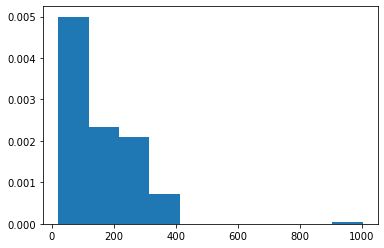

In [9]:
cum_rs = []
for n_epi in range(offline_budget):
    obs = env.reset()
    cum_r = 0

    while True:
        action = offline_agent.act(obs.float().to(device), 0.1)
        next_obs, reward, done, info = env.step(make_action(action))

        experience = (
            obs.float().to(device),
            torch.tensor((action,)).float().to(device),
            torch.tensor((reward,)).float().to(device),
            next_obs.float().to(device),
            torch.tensor((done,)).float().to(device)
        )
        memory.push(experience)

        obs = next_obs
        cum_r += 1
        if done:
            cum_rs.append(cum_r)
            break
            
plt.hist(cum_rs, density=True, label='expert')

## オフライン学習

In [10]:
batch_size = 1024
n_updates = 60000

Fitting: 60000/60000 |===========================================================>

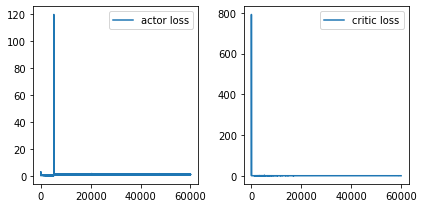

In [11]:
critic_losses, actor_losses = [], []
progbar = ">"
for i in range(n_updates):        
    obs, action, reward, next_obs, done = memory.sample(batch_size)
    critic_loss = agent.update_critic(obs, action.to(torch.int64), reward, next_obs, done)
    actor_loss = agent.update_actor(obs, action.to(torch.int64))
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())
    
    if i % 1000 == 0:
        print(f"\rFitting: {i+1000}/{n_updates} |{progbar}", end="")
        progbar = progbar.replace(">", "=") + ">"
        
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
fig.tight_layout()

In [12]:
torch.save(agent.state_dict(), "offline_agent.pt")

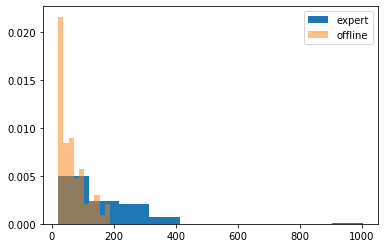

In [13]:
awac_cum_rs = []
for n_epi in range(offline_budget):
    obs = env.reset()
    cum_r = 0

    while True:
        action = agent.get_action(obs.float().to(device).unsqueeze(dim=0))
        next_obs, reward, done, info = env.step(make_action(action))

        obs = next_obs
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break

plt.hist(cum_rs, density=True, label='expert')
plt.hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
plt.legend()

## ファインチューニング

In [14]:
online_budget = 1000
online_awac_cum_rs = []
progbar = ">"
for n_epi in range(online_budget):
    obs = env.reset()
    cum_r = 0

    while True:
        action = agent.get_action(obs.float().to(device).unsqueeze(dim=0))
        next_obs, reward, done, info = env.step(make_action(action))

        experience = (
            obs.float().to(device),
            torch.tensor((action,)).float().to(device),
            torch.tensor((reward,)).float().to(device),
            next_obs.float().to(device),
            torch.tensor((done,)).float().to(device)
        )
        memory.push(experience)
        
        obs = next_obs
        cum_r += 1
        if done:
            online_awac_cum_rs.append(cum_r)
            break
    
    print(f"\rEpisode: {n_epi+1}/{online_budget} |{progbar}", end="")
    progbar = progbar.replace(">", "=") + ">"
    
    if len(memory) >= batch_size:
        
        obs_, action_, reward_, next_obs_, done_ = memory.sample(batch_size)
        critic_loss = agent.update_critic(obs_, action_.to(torch.int64), reward_, next_obs_, done_)
        actor_loss = agent.update_actor(obs_, action_.to(torch.int64))
        critic_losses.append(critic_loss.detach())
        actor_losses.append(actor_loss.detach())

Episode: 1000/1000 |====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

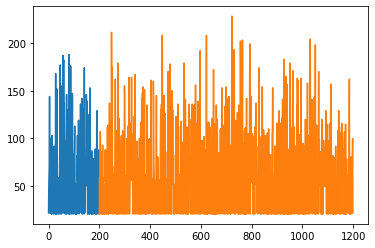

In [15]:
plt.plot(range(len(awac_cum_rs)), awac_cum_rs)
plt.plot(range(len(awac_cum_rs), 
               len(awac_cum_rs + online_awac_cum_rs)), 
         online_awac_cum_rs)

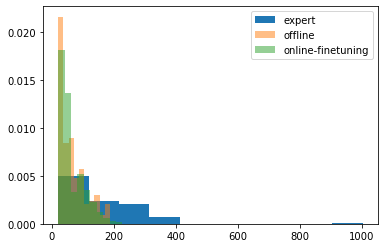

In [16]:
plt.hist(cum_rs, density=True, label='expert')
plt.hist(awac_cum_rs, alpha=0.5, density=True, label='offline')
plt.hist(online_awac_cum_rs, alpha=0.5, density=True, label='online-finetuning')
plt.legend()

In [20]:
def valid():
    
    for n_epi in range(10):
        obs = env.reset()
        cum_r = 0
        done = False
        
        while not done:
            action = agent.get_action(obs.float().to(device).unsqueeze(dim=0))
            next_obs, reward, done, info = env.step(make_action(action))
            obs = next_obs
            
valid()